# PPV Analysis and Fine-Tuning
2025-9-25

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

From the previous RF Classifier, I demonstrated that 'package name' has significant variable importance, followed by 'gross price', 'net price', and # of nights stayed. Whereas the 'month' variables have relatively low importance, and the # of rooms likely has no importance as suggested by the model. I will remove the vendor account variables for the following analysis because I suspect those are highly correlated with package name in some ways. After hyperparameter tuning using 5 fold CV and grid search algorithm, I found that the best parameter uses the following {m=sqrt, n=400} to get the best CV F1-score of 0.887455. In the following analysis, I will start by doing EDA on the relationship between package names for March-August 6-month data, then dig deeper by sampling POs as suggested by Shona. 

In [30]:
three_month_df = pd.read_csv('data/June_August.csv') # June August Dataset
print("Three-Month Bookings DF Columns:")
print(three_month_df.columns.tolist())
print("\nShape:", three_month_df.shape)
print(three_month_df.info())
print(three_month_df.describe().T)

Three-Month Bookings DF Columns:
['vendor_account', 'purchase_order', 'booking_number', 'net_amount', 'discount', 'unit_price', 'currency', 'requested_receipt_date', 'procurement_category', 'line_status', 'line_number', 'quantity', 'group']

Shape: (17507, 13)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17507 entries, 0 to 17506
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   vendor_account          17507 non-null  object 
 1   purchase_order          17507 non-null  object 
 2   booking_number          17505 non-null  object 
 3   net_amount              17507 non-null  float64
 4   discount                17507 non-null  float64
 5   unit_price              17507 non-null  float64
 6   currency                17507 non-null  object 
 7   requested_receipt_date  17507 non-null  object 
 8   procurement_category    17507 non-null  object 
 9   line_status             17507 non-null  ob

In [43]:
# 6-months data overview
six_month_df = pd.read_csv('data/PPV_March_August.csv')
print("Six-Month Bookings DF Columns:")
print(six_month_df.columns.to_list())
print("\nShape:", six_month_df.shape)
print(six_month_df.info())
print(six_month_df.describe().T) # transpose for easier reading

Six-Month Bookings DF Columns:
['vendor_account', 'purchase_order', 'booking_number', 'net_amount', 'discount', 'unit_price', 'currency', 'requested_receipt_date', 'procurement_category', 'line_status', 'line_number', 'quantity', 'group']

Shape: (34706, 13)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34706 entries, 0 to 34705
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   vendor_account          34706 non-null  object 
 1   purchase_order          34706 non-null  object 
 2   booking_number          34704 non-null  object 
 3   net_amount              34706 non-null  float64
 4   discount                34706 non-null  float64
 5   unit_price              34706 non-null  float64
 6   currency                34706 non-null  object 
 7   requested_receipt_date  34706 non-null  object 
 8   procurement_category    34706 non-null  object 
 9   line_status             34706 non-null  obje

In [44]:
# distribution plot of discount (unwiesghted)
'''plt.figure(figsize=(5, 3))
sns.histplot(three_month_df['discount'], kde=True, bins=250, color="royalblue")
plt.title("Distribution of Discount (June - August)", fontsize=12)
plt.xlabel("Discount")
plt.ylabel("Frequency")
plt.xlim(0, 200)
plt.tight_layout()
plt.show() '''

'plt.figure(figsize=(5, 3))\nsns.histplot(three_month_df[\'discount\'], kde=True, bins=250, color="royalblue")\nplt.title("Distribution of Discount (June - August)", fontsize=12)\nplt.xlabel("Discount")\nplt.ylabel("Frequency")\nplt.xlim(0, 200)\nplt.tight_layout()\nplt.show() '

In [50]:
# run a test of lowerbound in total 6 month data
def discount_stats_lower_bound(df, lower):
    '''Computer the mean discount including only rows with discount greater than lower'''
    filtered = df[df['discount'] > lower]
    avg = filtered['discount'].mean()
    count = filtered.shape[0]
    return avg, count

# test different lower bounds
for lower in [-100, 0, 1, 2, 3, 4, 5, 10]:
    avg, n = discount_stats_lower_bound(six_month_df, lower)
    print(f"Lower bouund ${lower}: Average Discount = {avg:.2f}, Count = {n} bookings")

Lower bouund $-100: Average Discount = 24.56, Count = 34706 bookings
Lower bouund $0: Average Discount = 69.52, Count = 12290 bookings
Lower bouund $1: Average Discount = 74.19, Count = 11514 bookings
Lower bouund $2: Average Discount = 80.34, Count = 10616 bookings
Lower bouund $3: Average Discount = 84.08, Count = 10130 bookings
Lower bouund $4: Average Discount = 84.92, Count = 10026 bookings
Lower bouund $5: Average Discount = 85.92, Count = 9902 bookings
Lower bouund $10: Average Discount = 88.66, Count = 9573 bookings


In [55]:
# run a test of upperbound 
def discount_stats_upper_bound(df, upper):
    '''Computer the mean discount including only rows with discount less than upper'''
    filtered = df[df['discount'] < upper]
    avg = filtered['discount'].mean()
    count = filtered.shape[0]
    return avg, count

# test different upper bounds
for upper in [500, 400, 300, 250, 200, 150, 100, 50, 25, 10]:
    avg, n = discount_stats_upper_bound(six_month_df, upper)
    print(f"Upper bouund ${upper}: Average Discount = {avg:.2f}, Count = {n} bookings")

Upper bouund $500: Average Discount = 16.24, Count = 34425 bookings
Upper bouund $400: Average Discount = 15.11, Count = 34336 bookings
Upper bouund $300: Average Discount = 13.06, Count = 34126 bookings
Upper bouund $250: Average Discount = 12.23, Count = 34019 bookings
Upper bouund $200: Average Discount = 11.38, Count = 33883 bookings
Upper bouund $150: Average Discount = 10.51, Count = 33709 bookings
Upper bouund $100: Average Discount = 9.36, Count = 33368 bookings
Upper bouund $50: Average Discount = 5.69, Count = 31350 bookings
Upper bouund $25: Average Discount = 1.36, Count = 27558 bookings
Upper bouund $10: Average Discount = 0.14, Count = 25123 bookings


A logical lower bound to use would be $3, because it does not seem to change too much above ($4) or below that point ($2). A logical upper bound value is around $250, it seems to include 95% of the data while excluding the extreme values like the $8764 max value. 

In [58]:
# Filter with lower and upper values
filtered = six_month_df[(six_month_df['discount'] >= 3) & (six_month_df['discount'] <= 250)]

print("summary stats for discounts in [lower, uppper]")
print(filtered['discount'].describe()) # this count below is the actual PPV out of 34000 bookings

summary stats for discounts in [lower, uppper]
count    9445.000000
mean       43.995537
std        39.424794
min         3.000000
25%        17.960000
50%        37.700000
75%        53.850000
max       250.000000
Name: discount, dtype: float64


### Illustrate Discount Group by Vendor Using Different Methods

In [65]:
def vendor_discount_stats(df, lower=None, upper=None):
    '''Compute grouped descriptive stats for discounts by vendor,
    with optional lower and upper bound
    '''
    filtered = df.copy()
    if lower is not None: 
        filtered = filtered[filtered['discount'] >= lower]
    if upper is not None: 
        filtered = filtered[filtered['discount'] <= upper]

    stats = (
        filtered.groupby("vendor_account")["discount"]
        .agg(["count", "mean", "median", "std", "min", "max"])
        .sort_values("mean", ascending=False)
    )
    return stats

# usage: 
stats = vendor_discount_stats(six_month_df, lower=3, upper=250)
print(stats.head(20))

                 count        mean   median         std     min     max
vendor_account                                                         
HAWAIPOULIBEACH     51  172.144314  188.480   65.006659    3.29  238.85
HAKOAKEAHOTEL        8  165.551250  224.115   95.345594   23.60  235.92
HANAPILIKAIBEAC      3  157.420000  209.400   96.113718   46.51  216.35
HAKAUAISHORES       23  150.472174  200.000   75.034522   29.50  250.00
HAFOURSEASWAILE      8  130.706250  142.835   50.403709   64.85  181.79
HAWAILEAEKAHI        2  128.605000  128.605    0.021213  128.59  128.62
HATWOKAANAPALI       2  128.555000  128.555  144.582124   26.32  230.79
HAKAILUAPACIFIC    182  120.218956  117.920   49.282273   29.49  236.00
HAROYALKONA         20  120.077500  117.960   53.999230   29.49  235.92
HAROYALHIGHGATE     50  113.052600  130.700   72.701447    3.07  247.74
HAHILOHAWAIIAN      40  109.100250   79.740   76.297524    3.00  247.73
HAKAUAIBLUE          9  105.197778  100.200   53.954336   47.08 

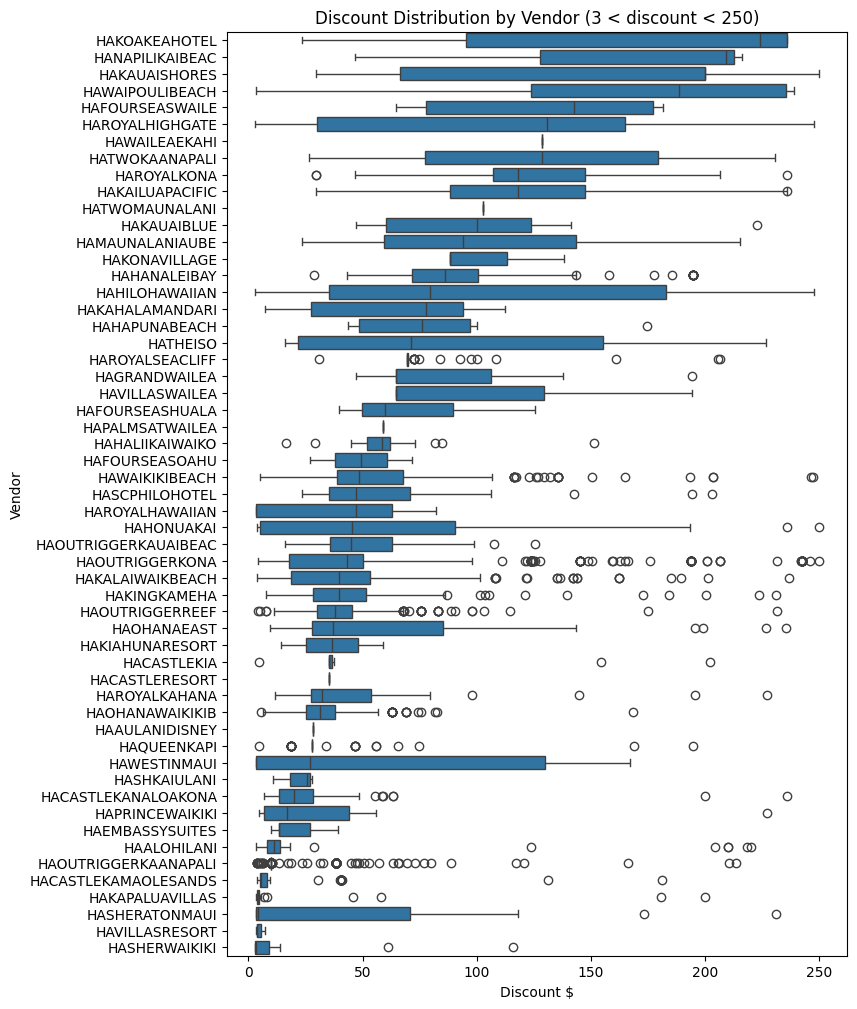

In [81]:
# box plot
def vendor_discount_boxplot(df, lower=None, upper=None):
    filtered = df.copy()
    if lower is not None: 
        filtered = filtered[filtered['discount'] >= lower]
    if upper is not None: 
        filtered = filtered[filtered['discount'] <= upper]
    
    # computer median discount per vendor
    vendor_order = (
        filtered.groupby("vendor_account")["discount"]
        .median()
        .sort_values(ascending=False)
        .index
    )

    plt.figure(figsize=(8,12))
    sns.boxplot(y="vendor_account", x="discount", data=filtered, orient="h", order=vendor_order)
    plt.xlabel("Discount $")
    plt.ylabel("Vendor")
    plt.title(f"Discount Distribution by Vendor ({lower} < discount < {upper})")
    plt.show()

#usage
vendor_discount_boxplot(six_month_df, lower=3, upper=250)

Dots are outliers, the shaded box represent Q1-Q3 (25% - 75%) of data, the line in the middle is the median. 

C:\Users\gavin.qu\AppData\Local\Temp\ipykernel_25352\825949399.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  filtered.groupby(['vendor_account', 'discount_bin'])


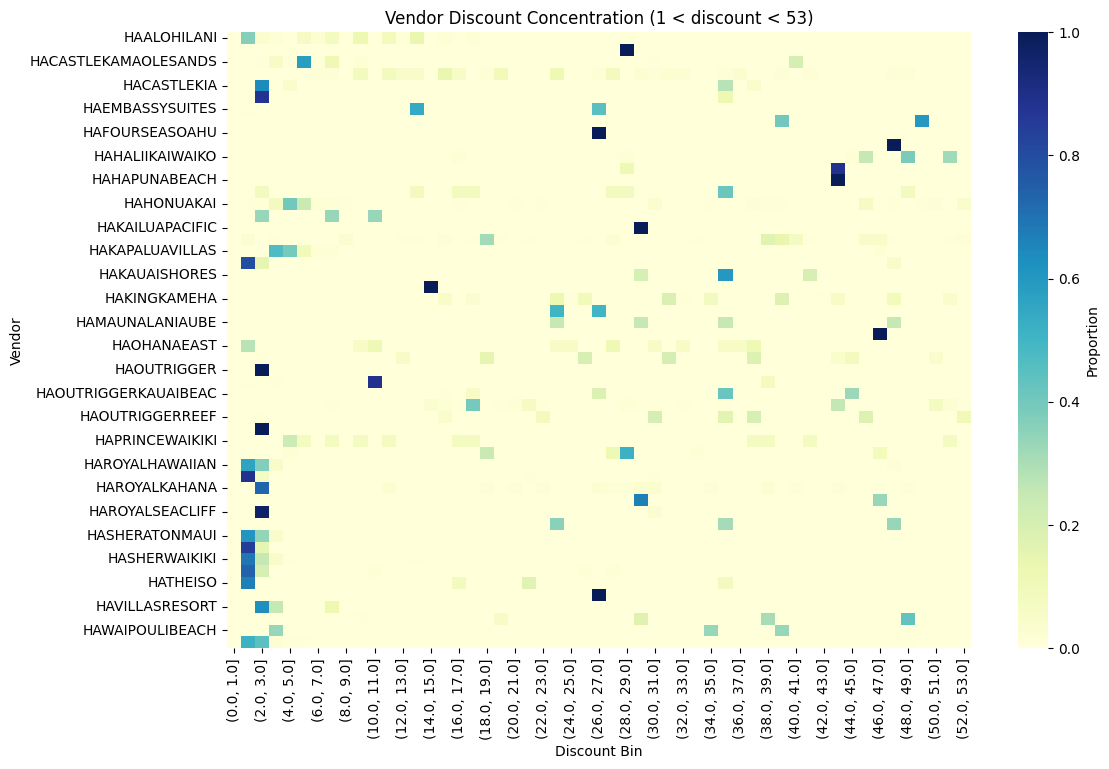

In [80]:
# outlier and concentration analysis via modes and heatmap
def vendor_discount_concentration(df, lower=None, upper=None, bin_size=5):
    filtered = df.copy()
    if lower is not None: 
        filtered = filtered[filtered['discount'] >= lower]
    if upper is not None: 
        filtered = filtered[filtered['discount'] <= upper]
    
    # create bins
    bins = np.arange(0, filtered['discount'].max() + bin_size, bin_size)
    filtered['discount_bin'] = pd.cut(filtered['discount'], bins)

    # count % of bookimnsg per vendor per bin
    heatmap_data = (
        filtered.groupby(['vendor_account', 'discount_bin'])
        .size()
        .unstack(fill_value=0)
    )
    # normalize by row
    heatmap_data = heatmap_data.div(heatmap_data.sum(axis=1), axis=0)

    plt.figure(figsize=(12,8))
    sns.heatmap(heatmap_data, cmap="YlGnBu", cbar_kws={'label': 'Proportion'})
    plt.title(f"Vendor Discount Concentration ({lower} < discount < {upper})")
    plt.ylabel("Vendor")
    plt.xlabel("Discount Bin")
    plt.show()

#usage
vendor_discount_concentration(six_month_df, lower=1, upper=53, bin_size=1)

Play around with the lower and upper value for the heatmap and you'll see there's a lot of randomness among vendors, which proves the legitimacy of my Random Forest Model from earlier which placed significant weight on the pacakge names, which I will examine in the following section.

## Demonstrate Discount Groups by package type

In [83]:
compass_df = pd.read_csv('data/compass_report.csv')
print("Column Names:", compass_df.columns.tolist())
print("Shape:",compass_df.shape)
print(compass_df.info())
print(compass_df.describe().T)

Column Names: ['program', 'Destination', 'Region', 'Package_Name', 'booking_number', 'Reservation_type', 'Membership_Type', 'Hotel_Name', 'Category', 'Sub_Category', 'Booked_Date', 'Check_In_Date', 'Check_Out_Date', 'textbox43', 'No_of_Rooms', 'No_of_Nights_Staying', 'No_of_Nights_In_Period', 'textbox45', 'Net_Price', 'Gross_Price', 'textbox25', 'Textbox56', 'Textbox59', 'Hotel_Name_1', 'No_of_Nights_In_Period_1', 'Net_Price_1', 'Gross_Price_1', 'textbox27']
Shape: (95741, 28)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95741 entries, 0 to 95740
Data columns (total 28 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   program                   95741 non-null  object 
 1   Destination               95741 non-null  object 
 2   Region                    95741 non-null  object 
 3   Package_Name              95663 non-null  object 
 4   booking_number            95741 non-null  object 
 5   Reservation_type   

In [84]:
# check uniqueness of pakcage names
n_packages = compass_df['Package_Name'].nunique()
print(f"Number of unique Package_Name values: {n_packages}")

# sample a few of them
print(compass_df["Package_Name"].dropna().unique()[:20])

Number of unique Package_Name values: 214
["Oahu: 'Alohilani Resort Waikiki Beach Package"
 "Oahu: 'Alohilani Resort Waikiki Beach Limited-Time Package"
 'Hawaii Island: Waikoloa Beach Marriott Resort & Spa Package'
 'Oahu and Maui: 2-Island Package'
 'Hawaii Island and Oahu: 2-Island Package'
 'Oahu and Kauai: 2-Island Package' 'Kauai and Oahu: 2-Island Package'
 'Maui and Oahu: 2-Island Package'
 'Oahu and Hawaii Island: 2-Island Package' 'Oahu: 2-Hotel Package'
 'Oahu: Romer House Waikiki Package'
 'Oahu: Aston Waikiki Beach Tower Package'
 'Kauai: Kauai Shores Hotel Package'
 'Oahu: Your Way Hotel and Airfare Package'
 "Oahu: Queen Kapi'olani Hotel Package" 'Oahu: Waikiki Malia Package'
 'Oahu: Hilton Hawaiian Village® Waikiki Beach Resort Package'
 'Kauai: 1 Hotel Hanalei Bay Package'
 'Hawaii Island and Kauai: 2-Island Package'
 'Kauai: Ko`a Kea Resort on Poipu Beach Package']


### Checking for duplicates

In [85]:
# Merge pakcage name into six_month_df
merged_df = six_month_df.merge(
    compass_df[['booking_number', 'Package_Name']],
    on="booking_number", 
    how="left"
)

print("Merged DF shape:", merged_df.shape)
print("Columns after merge:", merged_df.columns.tolist())

Merged DF shape: (42541, 14)
Columns after merge: ['vendor_account', 'purchase_order', 'booking_number', 'net_amount', 'discount', 'unit_price', 'currency', 'requested_receipt_date', 'procurement_category', 'line_status', 'line_number', 'quantity', 'group', 'Package_Name']


In [89]:
# check if booking_number is unique in each dataset
print("Unique booking_number in total_df:", six_month_df['booking_number'].is_unique)
print("Unique booking_number in compass_df:", compass_df['booking_number'].is_unique)

# count duplicates
print("Duplicates in total_df:", six_month_df['booking_number'].duplicated().sum())
print("Duplicates in compass_df:", compass_df['booking_number'].duplicated().sum())


Unique booking_number in total_df: False
Unique booking_number in compass_df: False
Duplicates in total_df: 3855
Duplicates in compass_df: 9222


In [94]:
# drop duplicate booking numbers from compass report
compass_df = compass_df.drop_duplicates(subset=["booking_number"])

# merge again with main df
merged_df = six_month_df.merge(
    compass_df[["booking_number", "Package_Name"]], 
    on="booking_number", 
    how="left"
)

print("Merged Shape:", merged_df.shape)

Merged Shape: (34706, 14)


### Filter by Discount and Illustrate its Distribution by Package

In [95]:
def filter_discounts(df, lower=None, upper=None):
    filtered = df.copy()
    if lower is not None: 
        filtered = filtered[filtered['discount'] >= lower]
    if upper is not None: 
        filtered = filtered[filtered['discount'] <= upper]
    return filtered

In [ ]:
def package_discount_boxplot(df, lower=None, upper=None):
    filtered = filter_discounts(df, lower, upper)

    # rank poackage by median discount
    package_order = (
        filtered.groupby("Package_Name")["discount"]
        .median()
        .sort_values()
        .index
    )

    plt.figure(figsize=(12,10))
    sns.boxplot(
        y="Package_Name", 
        x="discount",
        data=filtered, 
        orient="h",
        order=package_order
    )
    plt.title(f"Discount Distribution by Package_Name ({lower} < discount ≤ {upper})")
    plt.xlabel("Discount")
    plt.ylabel("Package_Name (ranked by median discount)")
    plt.show()

# usage
package_discount_boxplot(merged_df,lower=3, upper=250) # we will revisit his plot, there are too many pakcage names

In [102]:
def package_discount_stats(df, lower=None, upper=None):
    filtered = filter_discounts(df, lower, upper)
    stats = (
        filtered.groupby("Package_Name")["discount"]
        .agg(["count", "mean", "median", "std", "min", "max"])
        .sort_values("median", ascending=False)
    )
    return stats

#usage
stats = package_discount_stats(merged_df, lower=3, upper=250)
print(stats.head(10).T)

Package_Name  Kauai: Waipouli Beach Resort and Spa by OUTRIGGER Limited-Time Package  \
count                                                  5.000000                        
mean                                                 235.604000                        
median                                               235.600000                        
std                                                    0.021909                        
min                                                  235.580000                        
max                                                  235.640000                        

Package_Name  Kauai: Ko`a Kea Resort on Poipu Beach Package  \
count                                              9.000000   
mean                                             155.936667   
median                                           212.320000   
std                                               93.735780   
min                                               23.600000   
max  

### Top Packages ranked by the number of discount records

In [103]:
def top_packages_by_discount_count(df, lower=None, upper=None, top_n=20):
    filtered = df.copy()
    if lower is not None:
        filtered = filtered[filtered['discount'] >= lower]
    if upper is not None:
        filtered = filtered[filtered['discount'] <= upper]

    # count rows per package name
    package_counts = (
        filtered.groupby("Package_Name")["discount"]
        .count()
        .sort_values(ascending=False)
        .head(top_n)
    )
    return package_counts

# usage
top20 = top_packages_by_discount_count(merged_df, lower=3, upper=250, top_n=20)
print(top20)

Package_Name
Oahu: OUTRIGGER Waikiki Beach Resort Package                           1537
Maui: OUTRIGGER Ka'anapali Beach Resort Package                        1010
Oahu: OUTRIGGER Reef Waikiki Beach Resort Package                       883
Oahu: OUTRIGGER Waikiki Beachcomber Hotel Package                       833
Oahu: Embassy Suites by Hilton Waikiki Beach Walk Package               384
Maui: Honua Kai Resort & Spa Package                                    337
Hawaii Island: OUTRIGGER Kona Resort and Spa Package                    329
Hawaii Island: Courtyard King Kamehameha's Kona Beach Hotel Package     310
Oahu: OUTRIGGER Waikiki Beachcomber Hotel Limited-Time Package          250
Oahu: Ka La'i Waikiki Beach Package                                     219
Oahu and Maui: 2-Island Package                                         186
Kauai: OUTRIGGER Kauai Beach Resort Package                             175
Maui: Kamaole Sands Package                                             165

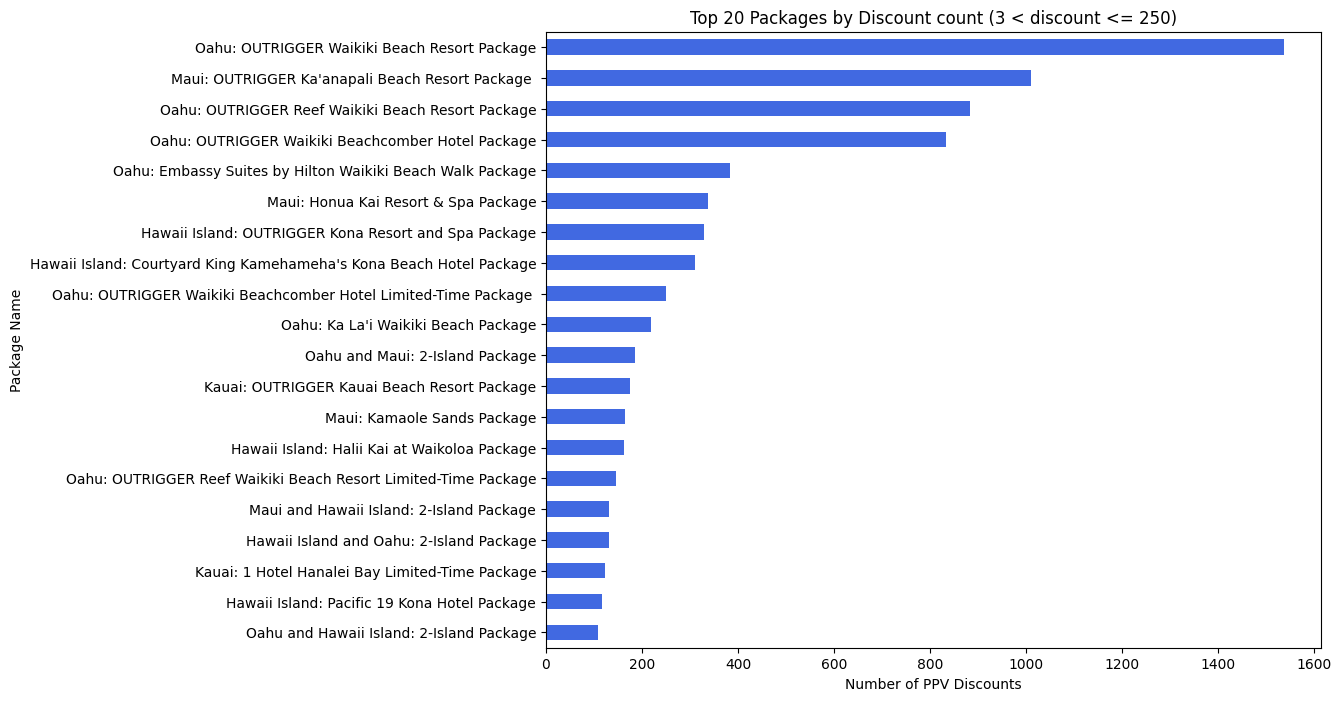

In [109]:
# horizontal bar plot
top20.plot(kind="barh", figsize=(10,8), color="royalblue")
plt.title("Top 20 Packages by Discount count (3 < discount <= 250)")
plt.xlabel("Number of PPV Discounts")
plt.ylabel("Package Name")
plt.gca().invert_yaxis() # highest at the top
plt.show()